# Assignment 1

1. Compare word frequencies between two works of a single author.
1. Compare word frequencies between works of two authors.
1. Are there some words preferred by one author but used less frequently by another author?

Extra credit

1. The frequency of a specific word, e.g., "would" should follow a binomial distribution (each regular word in a document is a trial and with probability p that word is "would". The estimate for p is N("would")/N(regular word)). Do these binomial distributions for your chosen word differ significantly between books of the same author or between authors? 

Project Gutenberg is a good source of for fiction and non-fiction.

E.g below are two most popular books from Project Gutenberg:
- Pride and Prejudice at http://www.gutenberg.org/ebooks/1342.txt.utf-8
- Adventures of Huckleberry Finn at http://www.gutenberg.org/ebooks/76.txt.utf-8

In [26]:
import requests, re, nltk
#In case your text is not on Project Gutenberg but at some other URL
#http://www.fullbooks.com/Our-World-or-The-Slaveholders-Daughter2.html
# that contains 12 parts
t = ""
for i in range(2,13):
  r = requests .get('http://www.fullbooks.com/Our-World-or-The-Slaveholders-Daughter' + str(i) + '.html')
  t = t + r.text

In [27]:
len(t)

1323653

In [13]:
import requests, re, nltk, operator
from bs4 import BeautifulSoup
from nltk import clean_html
from collections import Counter
import numpy as np
import pylab
import matplotlib.pyplot as plt

nltk.download('stopwords')

# Retrieve URLs for comparison

# "The Iliad" by Homer
url_il = 'https://gutenberg.org/files/6130/6130-h/6130-h.htm'
# "The Odyssey" by Homer
url_od = 'https://gutenberg.org/files/1727/1727-h/1727-h.htm'
# "The Republic" by Plato
url_re = 'https://gutenberg.org/files/1497/1497-h/1497-h.htm'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
stop_words = nltk.corpus.stopwords.words('english') + [
 'ut', '\'re','.', ',', '--', '\'s', '?', ')', '(', ':', '\'',
 '\"', '-', '}', '{', '&', '|', u'\u2014' ]

def cleanHtml (html):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    return soup.get_text()

def cleanWord (w):
    wn = re.sub('[,"\.\'&\|:@>*;/=]', "", w)
    return re.sub('^[0-9\.]*$', "", wn)
       
def get_wf (URL):
    r = requests.get(URL)

    t = cleanHtml(r.text).lower()

    wds = re .split('\s+', t)

    for i in range(len(wds)):
        wds [i] = cleanWord(wds[i])
    
    wf = Counter(wds)

    for k in stop_words:
        wf.pop(k, None)

    tw = 0
    for w in wf:
       tw += wf[w] 

    wfs = sorted (wf.items(), key = operator.itemgetter(1), reverse = True)
    ml = min(len(wfs),15)

    return (wfs[0:ml][::-1], tw)

(wf_il, tw_il) = get_wf(url_il)
(wf_od, tw_od) = get_wf(url_od)
(wf_re, tw_re) = get_wf(url_re)

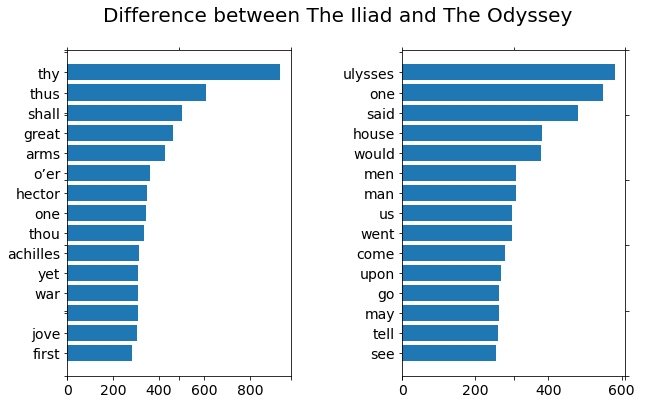

In [17]:
# PART 1 - Comparing two works by Homer

%matplotlib inline
def plotTwoLists (wf_ts, wf_hf, title):
    f = plt.figure (figsize=(10, 6))
    f .suptitle (title, fontsize=20)
    ax = f.add_subplot(111)
    ax.spines ['top'].set_color ('none')
    ax.spines ['bottom'].set_color ('none')
    ax.spines ['left'].set_color ('none')
    ax.spines ['right'].set_color ('none')
    ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=20)

    ax1 = f.add_subplot (121)
    plt.subplots_adjust (wspace=.5)

    # "The Iliad" sublot
    pos = np.arange (len(wf_il)+1) 
    ax1.tick_params (axis='both', which='major', labelsize=14)
    pylab.yticks (pos, [x[0] for x in wf_il])
    ax1.barh (range(len(wf_il)), [x[1] for x in wf_il], align='center')

    # "The Odyssey" subplot
    ax2 = f.add_subplot (122)
    ax2.tick_params (axis='both', which='major', labelsize=14)
    pos = np.arange (len(wf_od)+1) 
    pylab.yticks (pos, [x[0] for x in wf_od])
    ax2.barh (range (len(wf_od)), [x[1] for x in wf_od], align='center')

plotTwoLists (wf_il, wf_od, 'Difference between The Iliad and The Odyssey')

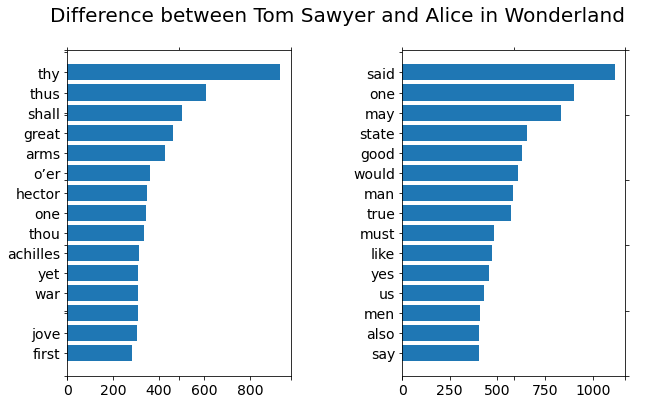

In [18]:
# PART 2 - Comparing "The Iliad" by Homer and "The Republic" by Plato

%matplotlib inline
def plotTwoLists (wf_ts, wf_hf, title):
    f = plt.figure (figsize=(10, 6))
    f.suptitle (title, fontsize=20)
    ax = f.add_subplot(111)
    ax.spines ['top'].set_color ('none')
    ax.spines ['bottom'].set_color ('none')
    ax.spines ['left'].set_color ('none')
    ax.spines ['right'].set_color ('none')
    ax.tick_params (labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=20)

    ax1 = f.add_subplot (121)
    plt.subplots_adjust (wspace=.5)

    # "The Iliad" sublot
    pos = np.arange(len(wf_il)+1) 
    ax1.tick_params(axis='both', which='major', labelsize=14)
    pylab.yticks(pos, [x[0] for x in wf_il])
    ax1.barh(range(len(wf_il)), [x[1] for x in wf_il], align='center')

    # "The Republic" subplot
    ax2 = f.add_subplot (122)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    pos = np.arange(len(wf_re)+1) 
    pylab.yticks(pos, [x[0] for x in wf_re])
    ax2.barh(range (len(wf_re)), [x[1] for x in wf_re], align='center')

plotTwoLists (wf_il, wf_re, 'Difference between Tom Sawyer and Alice in Wonderland')

**PART 3**

"Tom Sawyer" and "Alice in Wonderland" were published less than a decade apart from one another, but the language between the two novels appears relatively similar. As expected, both pieces use names of characters (Tom, Alice, Huck, Queen) as often as needed. Twain seems to use more auxillary verbs such as "would" and "could" than Carroll, which may be due to how the stories are told. Tom Sawyer's actions are interpreted from an outside perspective, using those words only as implications of what is happening, while Carroll uses more direct verbs to show active knowledge of what is happening to Alice.

***REDO ABOVE ^^^***